In [ ]:
!pip install numpy scipy matplotlib plotly

## HPR - 60 pontos


In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def HPR(p, C, param):
    """
    p : pontos
    C : posição do observador
    param : parâmetro do HPR
    """
    p = p.copy()
    n_p = p.shape[0] # Número de pontos
    dim_p = p.shape[1] # Dimensão dos pontos (no nosso caso, 3 sempre)

    # Move todos os pontos para a posição C vire origem (0, 0, 0)
    p = p - C

    # Norma de cada ponto ||p||
    norma_p = np.linalg.norm(p, axis=1)

    # Cálculo do raio da esfera
    r = np.max(norma_p) * (10**param)

    # Spherical flipping (inversão esférica)
    P = p + 2 * (r - norma_p)[:, None] * (p / norma_p[:, None]) # norma_p[:, None] aumenta a dimensão para poder fazer a conta

    # Fecho convexo dos novos pontos + origem
    origem = np.zeros((1, dim_p))
    total = np.vstack([P, origem]) # vstack empilha os arrays

    hull = ConvexHull(total) # Calcula o fecho convexo

    # Remove o índice da origem
    visiblePtInds = np.unique(hull.vertices) # Retorna só os vértices não se repetem
    visiblePtInds = visiblePtInds[visiblePtInds != n_p] # Tira o ponto n_p que é a origem (0, 0, 0)

    return visiblePtInds

# =====================================================
#                       MAIN
# =====================================================

# Quantos pontos serão inseridos?
n = int(input("Quantos pontos serão inseridos? "))

if n < 4:
  print("Precisa no mínimo quatro pontos que não sejam coplanares para fazer o fecho")
  exit()

pontos = []

for i in range(n):
  x, y, z = map(float, input().split())
  ponto = np.array([x, y, z])
  pontos.append(ponto)

x, y, z = map(float, input("Quais as coordenadas do observador? ").split())
C = np.array([x, y, z])
print()
if np.any(np.all(pontos == C, axis=1)):
  print("O observador não pode ser um ponto do conjunto.")
  exit()

pontos = np.array(pontos)

hull = ConvexHull(pontos)

print(f"Quantidade de faces triangulares do Fecho Convexo 3D = {len(hull.simplices)}")

visiveis = HPR(pontos, C, 1.5)

print("Índices visíveis:", visiveis)
print("Pontos visíveis:")
print(pontos[visiveis])
print()

# =====================================================
#                RENDERIZAÇÃO 3D DINÂMICA (Plotly)
# =====================================================

# Cria a figura para a plotagem
fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
                    subplot_titles=("Todos os Pontos", "Fecho Convexo", "HPR - Pontos Visíveis"))

# PLOT TODOS OS PONTOS

# Adiciona todos os pontos
fig.add_trace(
    go.Scatter3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
                 mode='markers', marker=dict(size=5, color='violet'), name='Pontos'),
    row=1, col=1
)
# Define o layout inicial
fig.update_scenes(
    xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    row=1, col=1
)


# PLOT FECHO CONVEXO

# Prepara os dados para as faces triangulares do Plotly
# O Plotly usa 'i', 'j', 'k' para os índices dos vértices de cada triângulo
faces = hull.simplices
i = faces[:, 0]
j = faces[:, 1]
k = faces[:, 2]

# Adiciona a superfície do Fecho Convexo
fig.add_trace(
    go.Mesh3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
              i=i, j=j, k=k,
              color='gray', opacity=0.3, name='Fecho Convexo',
              # Adiciona as linhas do wireframe
              flatshading=True,
              lighting=dict(ambient=0.5, diffuse=0.5, specular=0.5, roughness=0.5)),
    row=1, col=2
)

# Adiciona os pontos novamente para melhor visualização
fig.add_trace(
    go.Scatter3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
                 mode='markers', marker=dict(size=5, color='violet'), name='Pontos', showlegend=False),
    row=1, col=2
)
# Define o layout inicial
fig.update_scenes(
    xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    row=1, col=2
)


# PLOT HPR - PONTOS VISÍVEIS

# Plota todos os pontos em violeta
fig.add_trace(
    go.Scatter3d(x=pontos[:, 0], y=pontos[:, 1], z=pontos[:, 2],
                 mode='markers', marker=dict(size=5, color='violet', opacity=0.5),
                 name='Todos os pontos'),
    row=1, col=3
)

# Plota os pontos visíveis em azul
fig.add_trace(
    go.Scatter3d(x=pontos[visiveis, 0], y=pontos[visiveis, 1], z=pontos[visiveis, 2],
                 mode='markers', marker=dict(size=8, color='blue'),
                 name='Visíveis (HPR)'),
    row=1, col=3
)

# Plota o observador em vermelho (marcador 'X')
fig.add_trace(
    go.Scatter3d(x=[C[0]], y=[C[1]], z=[C[2]],
                 mode='markers', marker=dict(size=10, color='red', symbol='x'),
                 name='Observador'),
    row=1, col=3
)

# Adiciona o fecho convexo (wireframe)
# Para o wireframe no Plotly, é melhor plotar as faces como linhas
wireframe_x, wireframe_y, wireframe_z = [], [], []
for simplex in hull.simplices:
    pts = pontos[simplex]
    # Adicionar 3 arestas (ponto0, ponto1, None), (ponto1, ponto2, None), (ponto2, ponto0, None)
    for pair in [(0, 1), (1, 2), (2, 0)]:
        wireframe_x.extend([pts[pair[0], 0], pts[pair[1], 0], None])
        wireframe_y.extend([pts[pair[0], 1], pts[pair[1], 1], None])
        wireframe_z.extend([pts[pair[0], 2], pts[pair[1], 2], None])

fig.add_trace(
    go.Scatter3d(x=wireframe_x, y=wireframe_y, z=wireframe_z,
                 mode='lines', line=dict(color='gray', width=2),
                 name='Fecho Convexo (Wireframe)', showlegend=False),
    row=1, col=3
)

# Define o layout inicial
fig.update_scenes(
    xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
    row=1, col=3
)

# Ajusta o título e mostra a figura
fig.update_layout(title_text="Visualização Dinâmica 3D dos Resultados (Plotly)", height=600)
fig.show()

## Quick Hull


In [ ]:
import numpy as np
import random

EPS = 1e-9  # Ajuste para números muito pequenos

#------------------------------------------------------------------------
# FUNÇÕES AUXILIARES
#------------------------------------------------------------------------

# Função para garantir que a normal da face está apontada para fora
def get_orientada(face_hash, pontos_dict, centroide):
    a, b, c = (pontos_dict[ph] for ph in face_hash) # Vértices da normal
    normal = np.cross(b - a, c - a) # Cálculo da normal

    # Se a normal for > 0, EPS para ajustes de aproximação, ela está apontando para dentro
    if np.dot(normal, centroide - a) > EPS:
        return (face_hash[0], face_hash[2], face_hash[1])

    return face_hash

# Função para verificar se o ponto é visível a face
def visivel(p_array, face_hash, pontos_dict):
    a, b, c = (pontos_dict[ph] for ph in face_hash)
    normal = np.cross(b - a, c - a)

    return np.dot(normal, p_array - a) > EPS # Convencionalmente é > 0, mas pode dar problema, por isso usa o EPS

# Função para deixar em ordem crescente a aresta
def aresta_key(a_hash, b_hash):
    return tuple(sorted((a_hash, b_hash)))

#====================================================================================
#                                       MAIN
#====================================================================================
# Quantos pontos vão ser inseridos para montar o fecho
n = int(input("Quantos pontos serão inseridos? "))

# Conferência da quantidade de pontos para montar o fecho convexo 3D
if n < 4:
    print("É necessário ao menos 4 pontos não coplanares.")
    exit()

# Inicialização do dicionário de pontos em forma de coordenada (hash) tupla + arrays
pontos_hash_map = {}
# Inicialização do ponto em forma array (ID) -> tupla imutáveis
pontos = []

"""
Diferença de um ponto para um ponto_hash_map
ponto = (x, y, z)
ponto_hash_map[ponto] = np.array([x, y, z])
"""

# Leitura de todos os pontos e adiciona-os na lista e no dicionário
for i in range(n):
    x, y, z = map(float, input().split())
    p_array = np.array([x, y, z]) # Transforma o ponto lido em um array
    p_hash = tuple(p_array.tolist()) # Transforma o array em uma lista e depois em uma tupla (imutável)
    pontos_hash_map[p_hash] = p_array # Adiciona o array no ponto do dicionário
    pontos.append(p_hash) # Adiciona o ponto imutável na lista

#---------------------------------------------------------------------------------
# INICIALIZAÇÃO DO TETRAEDRO
#---------------------------------------------------------------------------------
# O primeiro ponto sempre vai ser o primeiro inserido
p1_hash = pontos[0]
p1 = pontos_hash_map[p1_hash]

# Encontrar os pontos que formem um tetraedro e maximizem o seu volume (evita que ele seja degenerado)
# p2 é o ponto mais longe de p0
p2_hash = max(pontos, key=lambda h: np.linalg.norm(pontos_hash_map[h] - p1))
p2 = pontos_hash_map[p2_hash]

# p3 é o ponto que maximiza a área do triângulo p1, p2, p3
u = p2 - p1 # Vetor auxiliar
p3_hash = max(pontos, key=lambda h: np.linalg.norm(np.cross(u, pontos_hash_map[h] - p1)))
p3 = pontos_hash_map[p3_hash]

# p4 é o ponto mais acima/abaixo do triângulo
v = p3 - p1 # Vetor auxiliar
base_normal = np.cross(u, v)

p4_hash = max(pontos, key=lambda h: abs(np.dot(base_normal, pontos_hash_map[h] - p1)))
p4 = pontos_hash_map[p4_hash]

vol = abs(np.dot(base_normal, p4 - p1))

if vol <= EPS: # Se não achar um tetraedro inicial, não é um fecho convexo 3D
    print("Os pontos são coplanares, não formam fecho convexo 3D.")
    exit()

# Cálculo da centroide do tetraedro
centro_tetra = (p1 + p2 + p3 + p4) / 4.0

# Dicionários com os pontos -> imutáveis do tetraedro
tetra = {p1_hash, p2_hash, p3_hash, p4_hash}

# Crio outra lista com uma permutação randômica com o resto dos pontos
resto_hashes = [p for p in pontos if p not in tetra]
random.shuffle(resto_hashes)

faces_iniciais = [ # Faces do tetraedro
    (p1_hash, p2_hash, p3_hash),
    (p1_hash, p3_hash, p4_hash),
    (p1_hash, p4_hash, p2_hash),
    (p2_hash, p4_hash, p3_hash)
]

# Organiza os vértices de cada face para apontarem sempre para fora do tetraedro
faces = [get_orientada(f, pontos_hash_map, centro_tetra) for f in faces_iniciais]

#---------------------------------------------------------------------------------
# GRAFO DE CONFLITO
#---------------------------------------------------------------------------------
# Incialização dos dicionários de pontos e faces
P_conflito = {f: [] for f in faces} # cada face pode ter um conjunto de pontos
F_conflito = {p: [] for p in resto_hashes} # cada ponto pode ter um conjunto de faces

# Verifica se o par (pr, f) é "visível", se o ponto "vê" a face
for pr_h in resto_hashes:
    p_array = pontos_hash_map[pr_h]
    for f in faces:
        if visivel(p_array, f, pontos_hash_map):
            P_conflito[f].append(pr_h)
            F_conflito[pr_h].append(f)

#---------------------------------------------------------------------------------
# LOOP PRINCIPAL
#---------------------------------------------------------------------------------
# Se o ponto tem alguma face associada, tem que ser inserido no fecho convexo
fila_pontos = [p for p in resto_hashes if F_conflito.get(p)] # Para dicionário, tem que usar get

while fila_pontos:
    pr_hash = fila_pontos.pop(0)
    pr_array = pontos_hash_map[pr_hash]

    faces_a_remover = list(F_conflito.get(pr_hash, [])) # Cria uma lista para todas as faces associadas a pr

    # Calculo do Horizonte e P(e)
    contagem_arestas = {} # Quantas faces removidas  compartilham a mesma aresta
    aresta_para_faces_antigas = {} # Quais faces antigas continham a aresta
    aresta_para_faces_orientadas = {} # Mapeia as arestas para formar o horizonte
    conflitos_removidos_cache = {} # Os pontos (pr) em conflito com a face

    for f in faces_a_remover:
        conflitos_removidos_cache[f] = list(P_conflito.get(f, [])) # Pega cada ponto para ser removido

        a_h, b_h, c_h = f # Vértices da face a remover

        for e in [(a_h, b_h), (b_h, c_h), (c_h, a_h)]: # e é uma aresta
            key = aresta_key(*e)
            # Se a aresta aparece mais de 1 vez, ela faz  parte do horizonte, caso contrário, ela é ponto interno
            contagem_arestas[key] = contagem_arestas.get(key, 0) + 1
            aresta_para_faces_antigas.setdefault(key, []).append(f)
            aresta_para_faces_orientadas.setdefault(key, []).append((e[0], e[1]))

    horizonte = [key for key, count in contagem_arestas.items() if count == 1]

    # Remoção das faces antigas
    for f in faces_a_remover:
        if f in faces:
            faces.remove(f)
        if f in P_conflito:
            del P_conflito[f]

    for pr_h in list(F_conflito.keys()): # Limpa o grafo F_conflito
        F_conflito[pr_h] = [f for f in F_conflito[pr_h] if f not in faces_a_remover]

    # Recalcula o centroide atual do fecho (média dos vértices únicos)
    v = set()
    for f in faces:
        v.update(f)
    if v:
        pts = np.array([pontos_hash_map[h] for h in v])
        centroide_atual = np.mean(pts, axis=0)
    else:
        centroide_atual = centro_tetra

    # Criação das novas faces
    novas_faces = []
    for key in horizonte:
        orienteda_list = aresta_para_faces_orientadas.get(key, [])
        if orienteda_list:
            a_h, b_h = orienteda_list[0]  # Pega a orientação que existia na face removida
        else:
            a_h, b_h = key
        candidato = (a_h, b_h, pr_hash)
        f_orientada = get_orientada(candidato, pontos_hash_map, centroide_atual)
        if f_orientada not in novas_faces:
            novas_faces.append(f_orientada)

    faces.extend(novas_faces)

    # Atualização do Grafo de conflito
    for f_nova in novas_faces:
        P_conflito[f_nova] = []

        a_h, b_h, i = f_nova
        key = aresta_key(a_h, b_h)

        p_candidatos = set()
        for f0 in aresta_para_faces_antigas.get(key, []):
            p_candidatos.update(conflitos_removidos_cache[f0]) # É o append() pra sets

        p_candidatos.discard(pr_hash) # É o pop() para sets

        for pr_h in p_candidatos:
            p_arr = pontos_hash_map[pr_h]
            if visivel(p_arr, f_nova, pontos_hash_map):
                P_conflito[f_nova].append(pr_h)
                F_conflito.setdefault(pr_h, []).append(f_nova)

    if pr_hash in F_conflito:
        del F_conflito[pr_hash]

    fila_pontos = [p for p in F_conflito.keys() if F_conflito.get(p)]

#---------------------------------------------------------------------------------
# RESULTADO
#---------------------------------------------------------------------------------
print()
print("Fecho convexo!")
print(f"Número total de faces: {len(faces)}")
print(faces)

##HPR - 180000 pontos

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- FUNÇÃO HPR (MANTIDA) ---
def HPR(p, C, param):
    """
    Horizon-Preserving Representation para determinar pontos visíveis.
    """
    p = p.copy()
    n_p = p.shape[0]
    dim_p = p.shape[1]
    p_trans = p - C
    norma_p = np.linalg.norm(p_trans, axis=1)
    r = np.max(norma_p) * (10**param)

    P = np.zeros_like(p_trans)
    non_zero_norm_mask = norma_p > 1e-9
    norma_p_nz = norma_p[non_zero_norm_mask]
    p_trans_nz = p_trans[non_zero_norm_mask]

    P[non_zero_norm_mask] = p_trans_nz + 2 * (r - norma_p_nz)[:, None] * (p_trans_nz / norma_p_nz[:, None])

    origem = np.zeros((1, dim_p))
    total = np.vstack([P, origem])
    hull = ConvexHull(total)

    visiblePtInds = np.unique(hull.vertices)
    visiblePtInds = visiblePtInds[visiblePtInds != n_p]

    return visiblePtInds

# =====================================================
#              GERAÇÃO DE ESTRELA DO MAR (ORGÂNICA)
# =====================================================

def gerar_estrela_do_mar(num_pontos, raio_base=5, altura=1.5, num_braços=5, rugosidade=0.1):
    """
    Gera pontos 3D que se assemelham a uma estrela do mar.
    """
    np.random.seed(42)

    angulos = np.random.uniform(0, 2 * np.pi, num_pontos)
    k = num_braços

    raio_modulado = (raio_base * 0.5) * (1 + np.cos(k * angulos)) + (raio_base * 0.5)
    raios = np.random.uniform(0, 1, num_pontos) * raio_modulado

    x = raios * np.cos(angulos)
    y = raios * np.sin(angulos)

    dist_ao_centro = np.linalg.norm(np.column_stack([x, y]), axis=1)
    z_base = altura * (1 - (dist_ao_centro / (raio_base * 1.5))**2)
    z_rugo = np.random.uniform(-rugosidade, rugosidade, num_pontos)
    z = z_base + z_rugo

    pontos_cima = np.column_stack([x, y, np.maximum(0.1, z)])
    pontos_baixo = np.column_stack([x, y, -np.maximum(0.1, z) / 4])

    pontos = np.vstack([pontos_cima[:num_pontos//2], pontos_baixo[num_pontos//2:]])

    return pontos

# --- Geração dos Pontos ---
n_total_pontos = 180000
pontos = gerar_estrela_do_mar(n_total_pontos)

# Observador: Próximo e ligeiramente acima da estrela do mar
C = np.array([5.0, 5.0, 8.0])

# =====================================================
#                  FECHO CONVEXO + HPR
# =====================================================
print(f"Número total de pontos gerados: {pontos.shape[0]}")
hull = ConvexHull(pontos)
# Índices dos pontos visíveis (contorno)
visiveis = HPR(pontos, C, 1.0)
print(f"Número de pontos visíveis (HPR): {len(visiveis)}")

# Índices dos pontos NÃO visíveis (o resto do corpo)
todos_indices = np.arange(pontos.shape[0])
invisiveis_mask = np.isin(todos_indices, visiveis, invert=True)
invisiveis = todos_indices[invisiveis_mask]


# =====================================================
#                 VISUALIZAÇÃO 3D
# =====================================================

tamanho_ponto = 0.5 # Ajustado para alta densidade

fig = make_subplots(rows=1, cols=3,
                    specs=[[{'type':'scatter3d'}, {'type':'scatter3d'}, {'type':'scatter3d'}]],
                    subplot_titles=("Estrela do Mar 3D - Todos os Pontos", "Fecho Convexo", "HPR - Pontos Visíveis"))

# --- 1. Todos os pontos
fig.add_trace(go.Scatter3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
                           mode='markers', marker=dict(size=tamanho_ponto, color='orange'), name='Pontos'),
              row=1, col=1)
fig.update_scenes(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', row=1, col=1)

# --- 2. Fecho Convexo
faces = hull.simplices
i = faces[:,0]
j = faces[:,1]
k = faces[:,2]
fig.add_trace(go.Mesh3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
                        i=i, j=j, k=k, color='lightgray', opacity=0.4,
                        flatshading=True,
                        lighting=dict(ambient=0.5, diffuse=0.5, specular=0.5, roughness=0.5),
                        name='Fecho Convexo'),
              row=1, col=2)
fig.add_trace(go.Scatter3d(x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
                           mode='markers', marker=dict(size=tamanho_ponto, color='orange'), showlegend=False),
              row=1, col=2)
fig.update_scenes(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', row=1, col=2)

# --- 3. HPR Pontos Visíveis (Distinção de Cores)

# A. Pontos NÃO Visíveis (Invisíveis) - Para dar corpo à estrela
# Usamos uma cor mais escura e mais transparente (cinza escuro) para o corpo.
fig.add_trace(go.Scatter3d(x=pontos[invisiveis, 0], y=pontos[invisiveis, 1], z=pontos[invisiveis, 2],
                           mode='markers', marker=dict(size=tamanho_ponto, color='gray', opacity=0.15),
                           name='Não Visíveis'), # Legenda da cor dos pontos invisíveis
              row=1, col=3)

# B. Pontos Visíveis (HPR) - O Contorno
fig.add_trace(go.Scatter3d(x=pontos[visiveis, 0], y=pontos[visiveis, 1], z=pontos[visiveis, 2],
                           mode='markers', marker=dict(size=1.0, color='blue'),
                           name='Visíveis (HPR)'), # Legenda da cor dos pontos visíveis
              row=1, col=3)

# C. Observador (vermelho)
fig.add_trace(go.Scatter3d(x=[C[0]], y=[C[1]], z=[C[2]],
                           mode='markers', marker=dict(size=7, color='red', symbol='x'),
                           name='Observador'),
              row=1, col=3)

# D. Wireframe (O contorno do Fecho Convexo - ajuda a contextualizar)
wire_x, wire_y, wire_z = [], [], []
for s in hull.simplices:
    pts = pontos[s]
    for pair in [(0,1),(1,2),(2,0)]:
        wire_x.extend([pts[pair[0],0], pts[pair[1],0], None])
        wire_y.extend([pts[pair[0],1], pts[pair[1],1], None])
        wire_z.extend([pts[pair[0],2], pts[pair[1],2], None])

fig.add_trace(go.Scatter3d(x=wire_x, y=wire_y, z=wire_z,
                           mode='lines',
                           line=dict(color='gray', width=1),
                           opacity=0.7,
                           showlegend=False),
              row=1, col=3)

fig.update_scenes(xaxis_title='X', yaxis_title='Y', zaxis_title='Z', row=1, col=3)
fig.update_layout(title_text="Estrela do Mar 3D (180.000 pontos) - Visíveis vs. Não Visíveis", height=600)
fig.show()

# HPR - 8 pontos

Quantos pontos serão inseridos? 8
0 0 0
0 0 1
0 1 0
0 1 1 
1 0 0 
1 0 1
1 1 0
1 1 1
Quais as coordenadas do observador? 0 0 5

Quantidade de faces triangulares do Fecho Convexo 3D = 12
Índices visíveis: [1 2 3 4 5 6 7]
Pontos visíveis:
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 1.]
 [1. 0. 0.]
 [1. 0. 1.]
 [1. 1. 0.]
 [1. 1. 1.]]



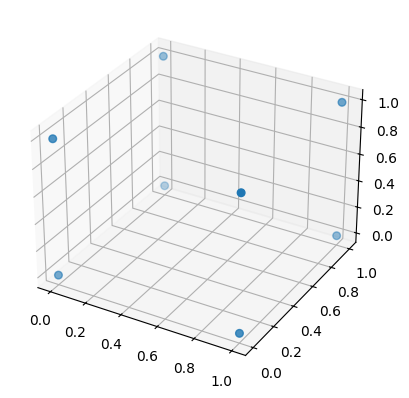

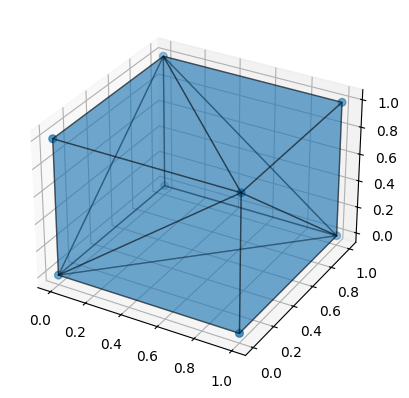

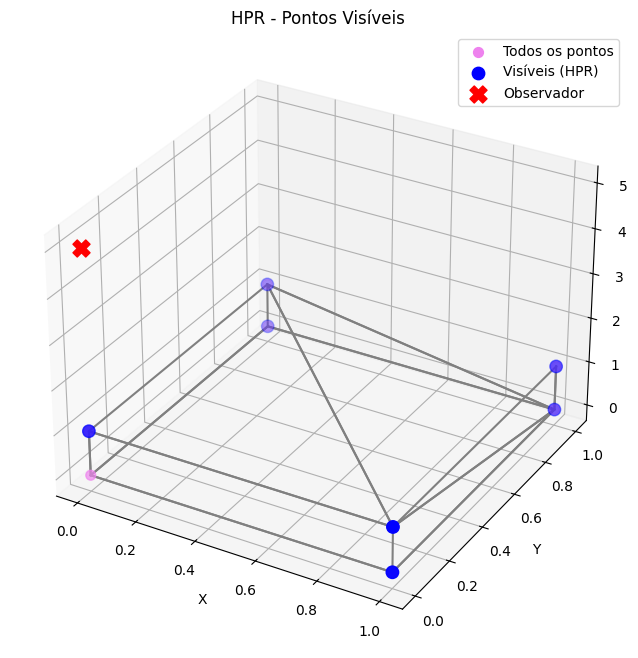

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull

def HPR(p, C, param):
    """
    p : pontos
    C : posição do observador
    param : parâmetro do HPR
    """

    p = p.copy()
    n_p = p.shape[0] # Número de pontos
    dim_p = p.shape[1] # Dimensão dos pontos (no nosso caso, 3 sempre)

    # Move todos os pontos para a posição C vire origem (0, 0, 0)
    p = p - C

    # Norma de cada ponto ||p||
    norma_p = np.linalg.norm(p, axis=1)

    # Cálculo do raio da esfera
    r = np.max(norma_p) * (10**param)

    # Spherical flipping (inversão esférica)
    P = p + 2 * (r - norma_p)[:, None] * (p / norma_p[:, None]) # norma_p[:, None] aumenta a dimensão para poder fazer a conta

    # Fecho convexo dos novos pontos + origem
    origem = np.zeros((1, dim_p))
    total = np.vstack([P, origem]) # vstack empilha os arrays

    hull = ConvexHull(total) # Calcula o fecho convexo

    # Remove o índice da origem
    visiblePtInds = np.unique(hull.vertices) # Retorna só os vértices não se repetem
    visiblePtInds = visiblePtInds[visiblePtInds != n_p] # Tira o ponto n_p que é a origem (0, 0, 0)

    return visiblePtInds

# =====================================================
#                       MAIN
# =====================================================

# Quantos pontos serão inseridos?
n = int(input("Quantos pontos serão inseridos? "))

if n < 4:
  print("Precisa no mínimo quatro pontos que não sejam coplanares para fazer o fecho")
  exit()

pontos = []

for i in range(n):
  x, y, z = map(float, input().split())
  ponto = np.array([x, y, z])
  pontos.append(ponto)

x, y, z = map(float, input("Quais as coordenadas do observador? ").split())
C = np.array([x, y, z])
print()
if np.any(np.all(pontos == C, axis=1)):
  print("O observador não pode ser um ponto do conjunto.")
  exit()

pontos = np.array(pontos)

hull = ConvexHull(pontos)

print(f"Quantidade de faces triangulares do Fecho Convexo 3D = {len(hull.simplices)}")

visiveis = HPR(pontos, C, 1.5)

print("Índices visíveis:", visiveis)
print("Pontos visíveis:")
print(pontos[visiveis])
print()

# =====================================================
#                RENDERIZAÇÃO 3D
# =====================================================
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Plot dos pontos
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Desenha os pontos
ax.scatter(pontos[:,0], pontos[:,1], pontos[:,2], s=30)

plt.show()
print()

# Plot do Fecho Convexo
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot dos pontos
ax.scatter(pontos[:,0], pontos[:,1], pontos[:,2], s=30)

# Criação das faces
polys = []

faces = hull.simplices

for a, b, c in faces:
    polys.append([pontos[a], pontos[b], pontos[c]])

# Adiciona as faces como triangulos
ax.add_collection3d(
    Poly3DCollection(polys, alpha=0.4, edgecolor='k')
)

plt.show()
print()

# Plot do HPR
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plota todos os pontos em azul
ax.scatter(pontos[:, 0], pontos[:, 1], pontos[:, 2], s=50, color='violet', label='Todos os pontos')

# Plota os pontos visíveis em verde
ax.scatter(pontos[visiveis, 0], pontos[visiveis, 1], pontos[visiveis, 2],
           s=80, color='blue', label='Visíveis (HPR)')

# Plota o observador em vermelho
ax.scatter(C[0], C[1], C[2], s=150, color='red', marker='X', label='Observador')

# Liga os vértices do fecho convexo (hull.original: seus pontos)
for simplex in hull.simplices:
    pts = pontos[simplex]
    ax.plot(pts[:, 0], pts[:, 1], pts[:, 2], color='gray')

ax.set_title("HPR - Pontos Visíveis")
ax.legend()
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.show()

HPR - plot 3

#HPR - 5000 pontos

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================
# FUNÇÃO HPR
# =========================
def HPR(p, C, param):
    p = p.copy()
    n_p = p.shape[0]
    dim_p = p.shape[1]

    p_trans = p - C
    norma_p = np.linalg.norm(p_trans, axis=1)
    r = np.max(norma_p) * (10**param)

    P = p_trans + 2 * (r - norma_p)[:, None] * (p_trans / norma_p[:, None])

    origem = np.zeros((1, dim_p))
    total = np.vstack([P, origem])

    hull = ConvexHull(total)

    visible = np.unique(hull.vertices)
    visible = visible[visible != n_p]

    return visible


# =========================
# TORO 3D (5000 pontos)
# =========================
def toro_3d(n=5000, R=4.0, r=1.2):
    np.random.seed(7)

    theta = np.random.uniform(0, 2*np.pi, n)
    phi = np.random.uniform(0, 2*np.pi, n)

    x = (R + r*np.cos(phi)) * np.cos(theta)
    y = (R + r*np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)

    ruido = np.random.normal(0, 0.12, (n, 3))
    return np.column_stack([x, y, z]) + ruido


# =========================
# DADOS
# =========================
pontos = toro_3d(5000)
C = np.array([8.0, -6.0, 6.0])

hull = ConvexHull(pontos)
visiveis = HPR(pontos, C, 1.0)

todos = np.arange(pontos.shape[0])
invisiveis = np.setdiff1d(todos, visiveis)


# =========================
# VISUALIZAÇÃO
# =========================
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type':'scatter3d'}, {'type':'scatter3d'}, {'type':'scatter3d'}]],
    subplot_titles=["Todos os Pontos", "Fecho Convexo", "HPR – Pontos Visíveis"]
)

# --- Todos os pontos
fig.add_trace(
    go.Scatter3d(
        x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
        mode='markers',
        marker=dict(size=2.5, color='orange')
    ),
    row=1, col=1
)

# --- Fecho Convexo
faces = hull.simplices
fig.add_trace(
    go.Mesh3d(
        x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
        i=faces[:,0], j=faces[:,1], k=faces[:,2],
        color='lightgray', opacity=0.4
    ),
    row=1, col=2
)

# --- HPR
fig.add_trace(
    go.Scatter3d(
        x=pontos[invisiveis,0], y=pontos[invisiveis,1], z=pontos[invisiveis,2],
        mode='markers',
        marker=dict(size=2, color='gray', opacity=0.2),
        name='Não visíveis'
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter3d(
        x=pontos[visiveis,0], y=pontos[visiveis,1], z=pontos[visiveis,2],
        mode='markers',
        marker=dict(size=3.5, color='blue'),
        name='Visíveis (HPR)'
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter3d(
        x=[C[0]], y=[C[1]], z=[C[2]],
        mode='markers',
        marker=dict(size=8, color='red', symbol='x'),
        name='Observador'
    ),
    row=1, col=3
)

fig.update_layout(
    title="Toro 3D – 5 000 pontos (HPR)",
    height=600
)

fig.show()


# HPR - 500 pontos

In [ ]:
import numpy as np
from scipy.spatial import ConvexHull
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# =========================
# FUNÇÃO HPR
# =========================
def HPR(p, C, param):
    p = p.copy()
    n_p = p.shape[0]
    dim_p = p.shape[1]

    p_trans = p - C
    norma_p = np.linalg.norm(p_trans, axis=1)
    r = np.max(norma_p) * (10**param)

    P = p_trans + 2 * (r - norma_p)[:, None] * (p_trans / norma_p[:, None])

    origem = np.zeros((1, dim_p))
    total = np.vstack([P, origem])

    hull = ConvexHull(total)

    visible = np.unique(hull.vertices)
    visible = visible[visible != n_p]

    return visible


# =========================
# ESPIRAL 3D (500 pontos)
# =========================
def espiral_3d(n=500):
    np.random.seed(3)

    t = np.linspace(0, 6*np.pi, n)
    r = 0.3 * t

    x = r * np.cos(t)
    y = r * np.sin(t)
    z = 0.15 * t

    # pequena espessura
    ruido = np.random.normal(0, 0.08, (n, 3))

    return np.column_stack([x, y, z]) + ruido


# =========================
# DADOS
# =========================
pontos = espiral_3d(500)
C = np.array([6.0, -6.0, 6.0])

hull = ConvexHull(pontos)
visiveis = HPR(pontos, C, 1.0)

todos = np.arange(pontos.shape[0])
invisiveis = np.setdiff1d(todos, visiveis)


# =========================
# VISUALIZAÇÃO
# =========================
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type':'scatter3d'}, {'type':'scatter3d'}, {'type':'scatter3d'}]],
    subplot_titles=["Todos os Pontos", "Fecho Convexo", "HPR – Pontos Visíveis"]
)

# --- Todos os pontos
fig.add_trace(
    go.Scatter3d(
        x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
        mode='markers',
        marker=dict(size=4, color='orange')
    ),
    row=1, col=1
)

# --- Fecho Convexo
faces = hull.simplices
fig.add_trace(
    go.Mesh3d(
        x=pontos[:,0], y=pontos[:,1], z=pontos[:,2],
        i=faces[:,0], j=faces[:,1], k=faces[:,2],
        color='lightgray', opacity=0.5
    ),
    row=1, col=2
)

# --- HPR
fig.add_trace(
    go.Scatter3d(
        x=pontos[invisiveis,0], y=pontos[invisiveis,1], z=pontos[invisiveis,2],
        mode='markers',
        marker=dict(size=3, color='gray', opacity=0.25),
        name='Não visíveis'
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter3d(
        x=pontos[visiveis,0], y=pontos[visiveis,1], z=pontos[visiveis,2],
        mode='markers',
        marker=dict(size=5, color='blue'),
        name='Visíveis (HPR)'
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter3d(
        x=[C[0]], y=[C[1]], z=[C[2]],
        mode='markers',
        marker=dict(size=8, color='red', symbol='x'),
        name='Observador'
    ),
    row=1, col=3
)

fig.update_layout(
    title="Espiral 3D – 500 pontos (HPR)",
    height=550
)

fig.show()
